The data in "calls.txt" is five-minute call volume for a large North American bank handled on weekdays between 7:00am and 9:05pm, beginning 3 March 2003 for 164 days.

- Create daily total calls data; this will be the data that you will be analysing from now on  
- If there is seasonality, what would be the period $s$?
- Split the data into training and test data-sets (reserve most recent $s$ data points for testing); from now on the steps below will be applied to the training data, except when you evaluate the forecasts
- Obtain the time series plot and interpret
- De-compose the series, interpret the plots
- Is log-transformation needed?
- Consider four series: 1) $X_t$ = original trainining set, 2) $Y_t = (1-B)X_t$, 3) $Z_t = (1-B^s)X_t$, 4) $K_t = (1-B)(1-B^s)X_t$
- Plot $X_t$, $Y_t$, $Z_t$, $K_t$ and interpret
- Obtain ACF and PACF plots of $X_t$, $Y_t$, $Z_t$, $K_t$ and interpret
- Check if $X_t$, $Y_t$, $Z_t$, $K_t$ are stationary, if not make them stationary
- Use auto ARIMA to find the best fitting model for each of $X_t$, $Y_t$, $Z_t$, $K_t$
- Check the diagnostics for residuals of the best fitting models for each of $X_t$, $Y_t$, $Z_t$, $K_t$  and interpret
- Do you think you can compare the best fitting models of $X_t$, $Y_t$, $Z_t$, $K_t$ in terms of AIC? Why and why not?
- Plot forecasts of the test series for the best models of $X_t$, $Y_t$, $Z_t$, $K_t$
- Compare the forecasting abilities of the best models of $X_t$, $Y_t$, $Z_t$, $K_t$ interpret. Why do you think the best performing model actually performed the best?
- Write down the model equation of the best fitting model you found the best forecasting model in the previous step 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
df = pd.read_csv('calls.txt')

- Create daily total calls data; this will be the data that you will be analysing from now on  

In [3]:
day = np.concatenate((np.ones(169) , np.zeros(119)))
for i in range(163):
    day = np.concatenate((day, np.concatenate((np.ones(169) , np.zeros(119)))))

x_day = pd.date_range('2003-03-01 07:00:00 ', periods=24*60*164/5, freq='5min')
idx_temp = pd.DataFrame({'Day':x_day, '5Min':day})
idx_temp = idx_temp[idx_temp['5Min'] == 1]
idx_temp = idx_temp.Day
df.index = idx_temp

dailySum = df.resample('D').sum()

y_day = pd.date_range(start = '2003-03-01', periods=230, freq='d')
y_day = pd.DataFrame({'Date':y_day})
y_day['WeekDay'] = y_day['Date'].dt.weekday
drop_index = [y_day[(y_day.WeekDay == 5)|(y_day.WeekDay == 6)].index]

dates = []
for i in y_day.Date:
    for j in range(164):
        dates.append(i)

for i in drop_index:
    y_day.drop(i, inplace = True)
dailySum.index = y_day.Date
dailySum

,x
Date,
2003-03-03,41257
2003-03-04,34975
2003-03-05,32039
2003-03-06,30912
2003-03-07,32695
...,...
2003-10-10,34293
2003-10-13,34056
2003-10-14,29598


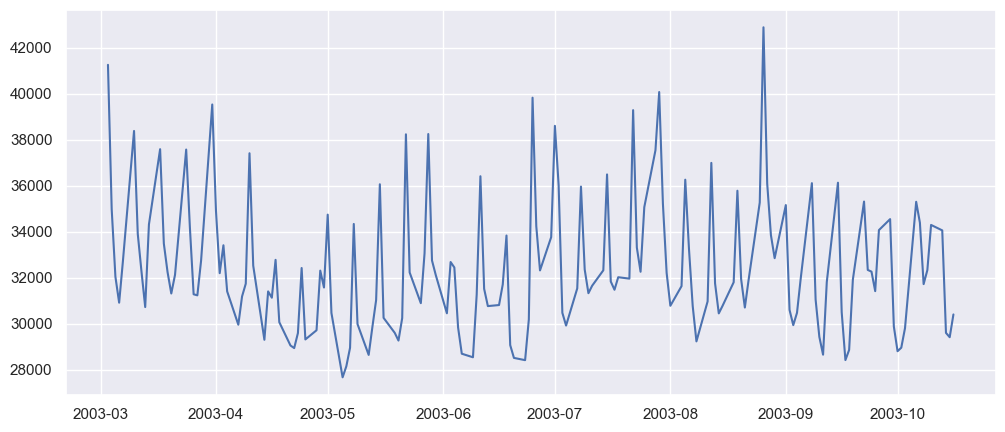

In [4]:
plt.figure(figsize = (12,5))
plt.plot(dailySum)

- If there is seasonality, what would be the period $s$?

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

<AxesSubplot:xlabel='Date'>

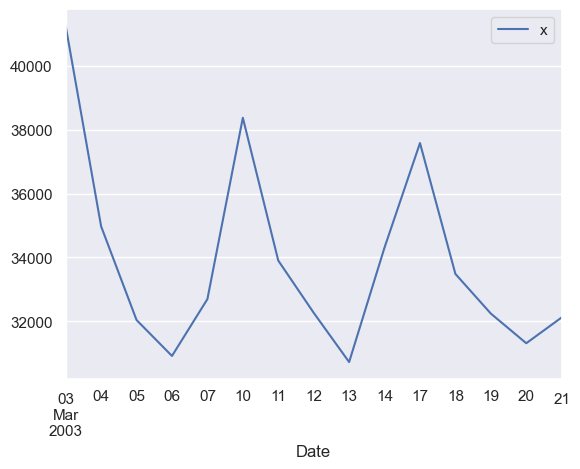

In [6]:
dailySum[:15].plot() #seasonal period is weekly

- Split the data into training and test data-sets (reserve most recent $s$ data points for testing); from now on the steps below will be applied to the training data, except when you evaluate the forecasts

In [7]:
s = 5 

In [8]:
train = dailySum[:-5]
test = dailySum[-5:]

- Obtain the time series plot and interpret

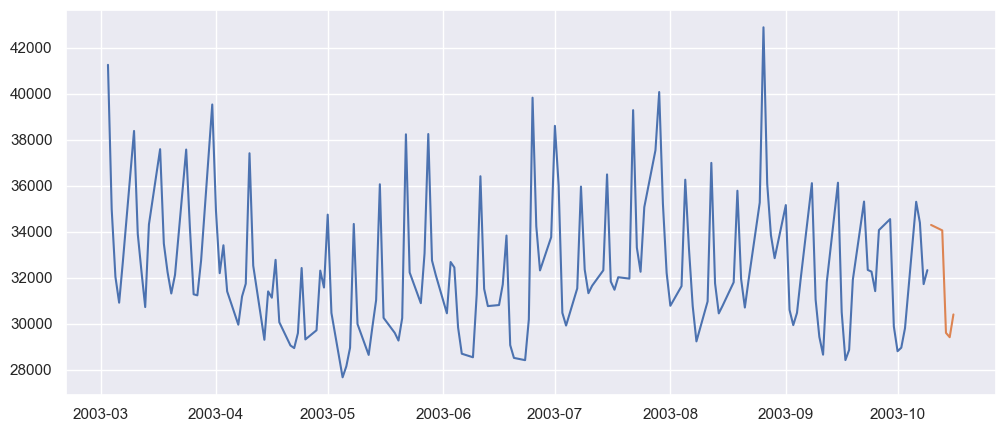

In [9]:
plt.figure(figsize = (12,5))
plt.plot(train)
plt.plot(test)

**- mean of the data seems constant.**

**- variance fructuates with seasonality.**

**- data seems to be stationary.**

- De-compose the series, interpret the plots

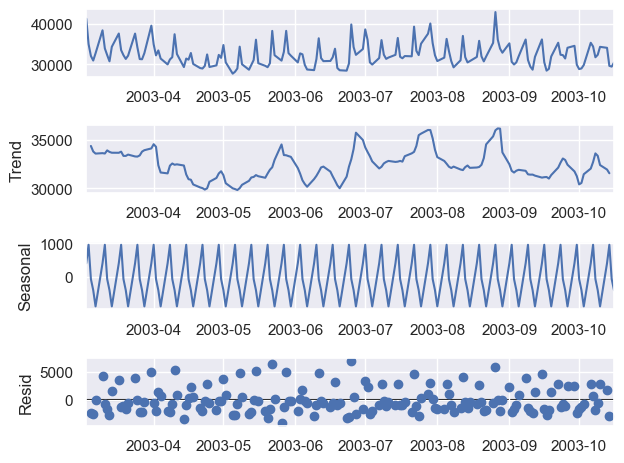

In [10]:
result = seasonal_decompose(dailySum, model='add')
result.plot();

**- There is a fluctuating trend.**

**- Seasonal period is week.**

**- Residuals seem like white noice for additive model.**

- Is log-transformation needed?

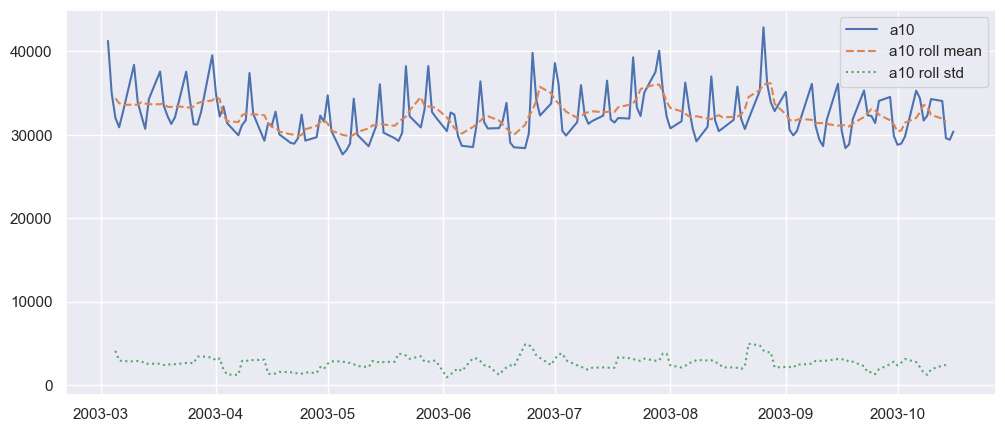

In [11]:
rolma10 = pd.Series.rolling(dailySum, window = 5, center = True).mean()
rolstda10 = pd.Series.rolling(dailySum, window = 5, center = True).std()

plt.figure(figsize = (12,5))
plt.plot(dailySum, label = 'a10')
plt.plot(rolma10, label = 'a10 roll mean', linestyle = '--')
plt.plot(rolstda10, label = 'a10 roll std', linestyle = ':')
plt.legend(); 
plt.show()

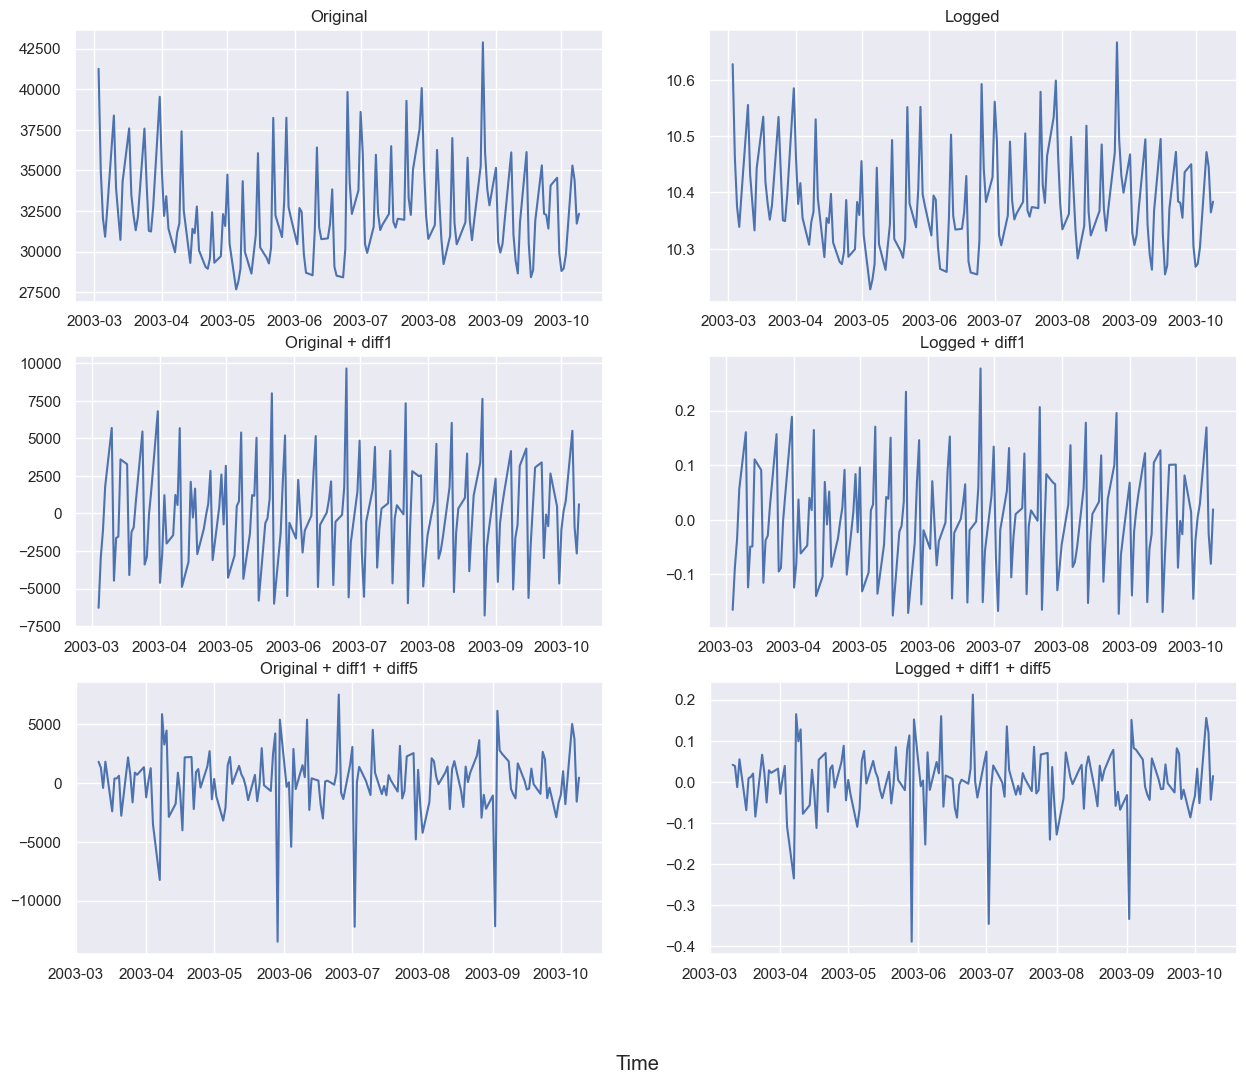

In [12]:
train_diff1 = train.diff(1).dropna()
train_diff1_diff5 = train_diff1.diff(5).dropna()
train_log = np.log(train).dropna()
train_log_diff1 = train_log.diff(1).dropna()
train_log_diff1_diff5 = train_log_diff1.diff(5).dropna()

figs, axs = plt.subplots(3, 2, figsize = (15, 12))
axs[0, 0].plot(train)
axs[0, 0].set_title('Original')
axs[0, 1].plot(train_log)
axs[0, 1].set_title('Logged')
axs[1, 0].plot(train_diff1)
axs[1, 0].set_title('Original + diff1')
axs[1, 1].plot(train_log_diff1)
axs[1, 1].set_title('Logged + diff1')
axs[2, 0].plot(train_diff1_diff5)
axs[2, 0].set_title('Original + diff1 + diff5')
axs[2, 1].plot(train_log_diff1_diff5)
axs[2, 1].set_title('Logged + diff1 + diff5')
figs.supxlabel('Time')
plt.show()

**Visually log transformation doesn't seem to make a difference. I will keep the original data.**

- Consider four series: 

    1) $X_t$ = original trainining set,
    
    2) $Y_t = (1-B)X_t$, 
    
    3) $Z_t = (1-B^s)X_t$, 
    
    4) $K_t = (1-B)(1-B^s)X_t$

In [13]:
X = train
Y = train_diff1
Z = train.diff(5).dropna()
K = train_diff1_diff5

- Plot $X_t$, $Y_t$, $Z_t$, $K_t$ and interpret

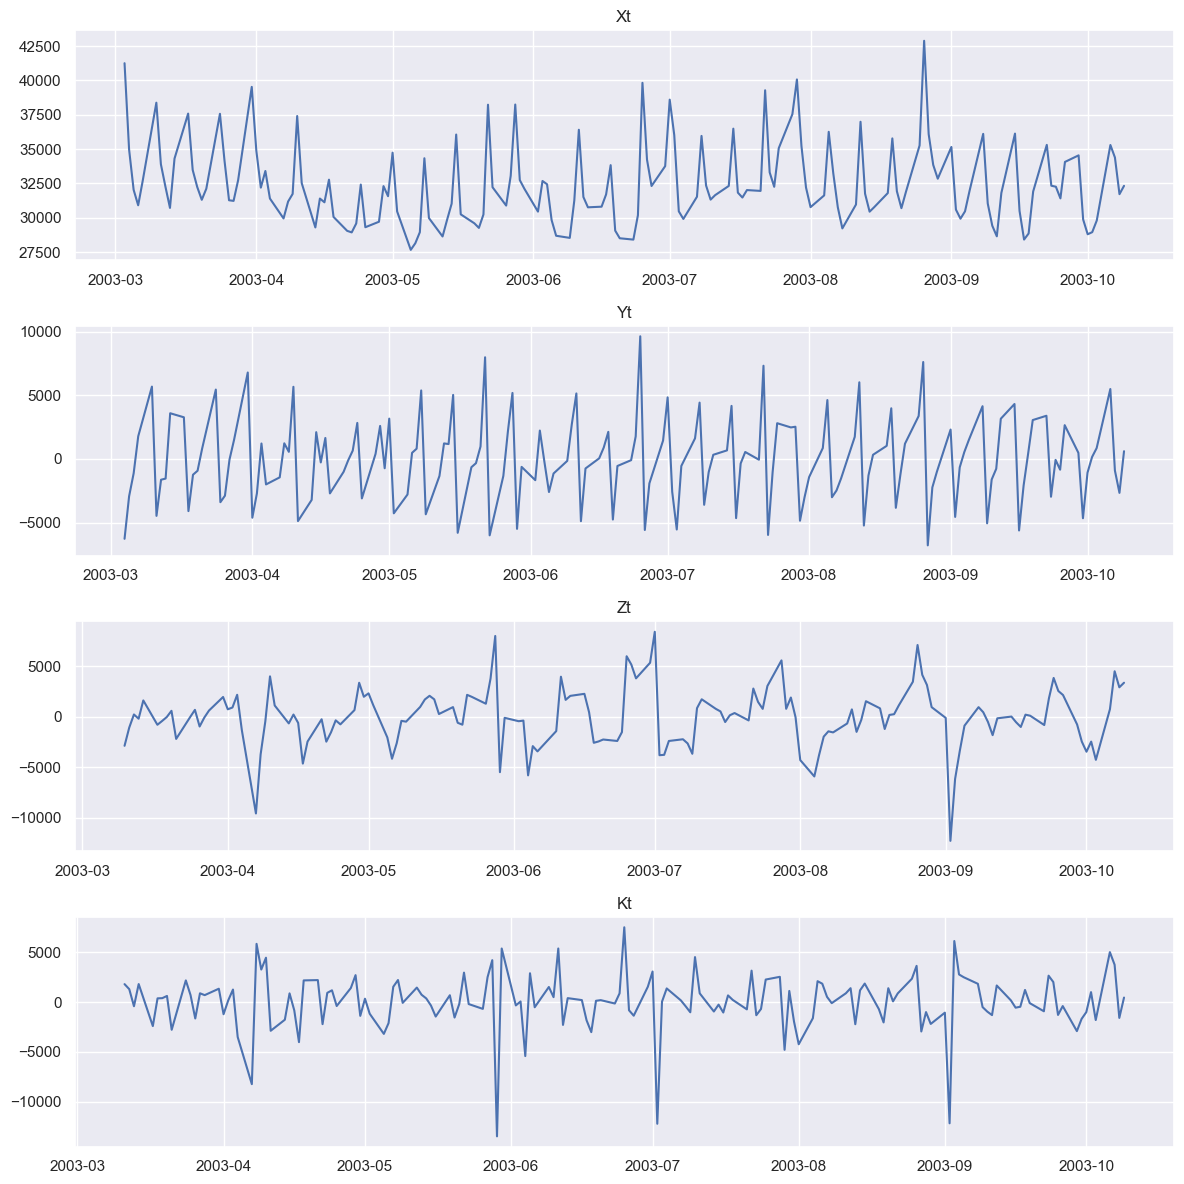

In [14]:
figs, axs = plt.subplots(4, 1, figsize = (12, 12))
axs[0].plot(X)
axs[0].set_title('Xt')
axs[1].plot(Y)
axs[1].set_title('Yt')
axs[2].plot(Z)
axs[2].set_title('Zt')
axs[3].plot(K)
axs[3].set_title('Kt')
plt.tight_layout()
plt.show()

Each of the graphs looks stationary.

- A: The 1st difference seems to smooth out the fluctuation of the data. Seasonality persists, but the data looks pretty smooth.
- Z: The differentiation to season 1 seems to have removed the seasonality, but there are some sharp drops.
- K: On top of the 1st difference, the 1st season difference softens the data even more, but the sharp drops seem sharper.

- Obtain ACF and PACF plots of $X_t$, $Y_t$, $Z_t$, $K_t$ and interpret

In [15]:
from PythonTsa.plot_acf_pacf import acf_pacf_fig

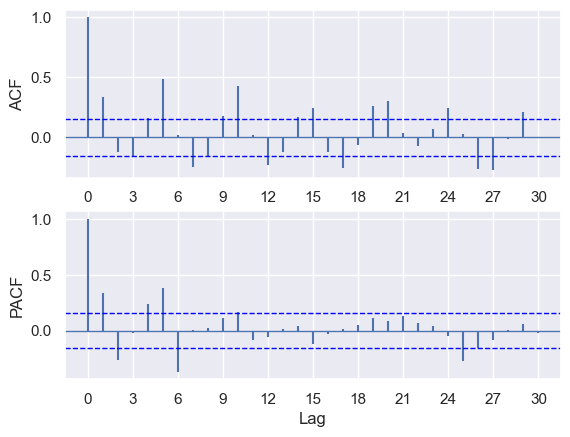

In [16]:
acf_pacf_fig(X, both=True)

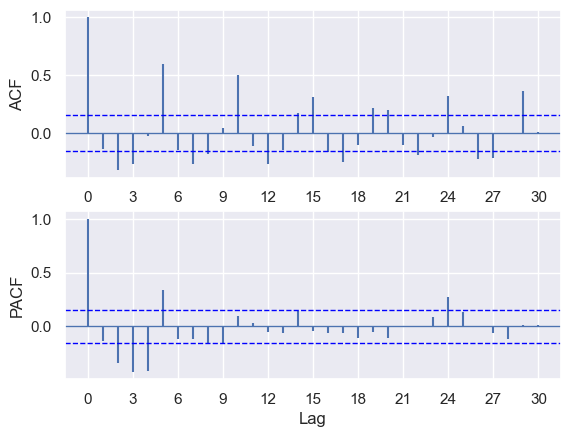

In [17]:
acf_pacf_fig(Y, both=True)

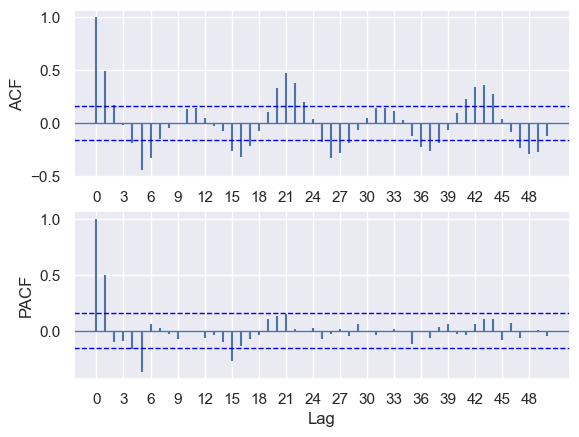

In [18]:
acf_pacf_fig(Z, both=True, lag=50)

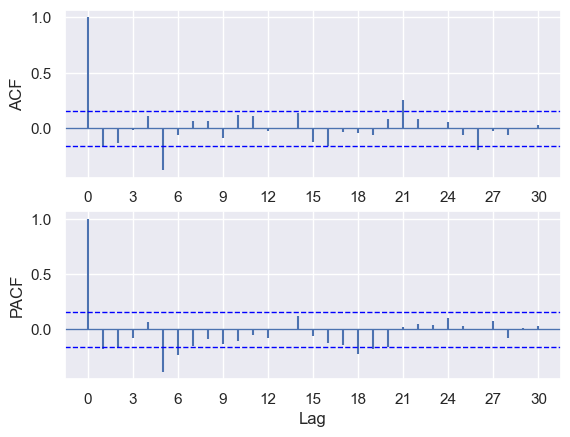

In [19]:
acf_pacf_fig(K, both=True)

For X and Y:

- ACF decays slowly. There is a high degree of autocorrelation between the observations at different lags. This means that the current observation is highly dependent on its past values.

- There are many significant lags in the PACF plot, it suggests that the time series may require a high-order AR model to adequately capture the autocorrelation in the data.

For Z:

- AF plot has significant lags on both positive and negative sides and does not decay after a point, it suggests that the time series may still be non-stationary.

- There are still significant lags on the PACF plot and they are on the seasonal periods(5th and 15th), which should be addressed at the AR side of the model. It is appropriate to use a seasonal model.

For K:

- There are only a few significant lags on both ACF and PACF plots, and they are on the seasonal periods, it suggests that this series has a seasonal component. It is appropriate to use a seasonal model.

- Check if $X_t$, $Y_t$, $Z_t$, $K_t$ are stationary, if not make them stationary

In [20]:
from statsmodels.tsa.stattools import adfuller, kpss
def ur_test(series):
    conclusion = list() ; pvalues=list()
    ALPHA = 0.05
    p_adf=adfuller(series)[1]
    p_kpss=kpss(series)[1]
    if p_adf > ALPHA and p_kpss <= ALPHA: conclusion='Not stationary' 
    if p_adf <= ALPHA and p_kpss > ALPHA: conclusion='Stationary' 
    if p_adf > ALPHA and p_kpss > ALPHA: conclusion='Trend-stationary (de-trend series)' 
    if p_adf <= ALPHA and p_kpss <= ALPHA: conclusion='Difference-stationary (difference series)' 
    print('p(adf)    :',p_adf)
    print('p(kpss)   :',p_kpss)
    print('Conclusion:',conclusion)

In [21]:
print('Original Data:')
ur_test(X)

print('\n1st diff:')
ur_test(Y)

print('\n1st seasonal diff:')
ur_test(Z)

print('\n1st diff + 1st seasonal diff:')
ur_test(K)

Original Data:
p(adf)    : 0.00019268357633144703
p(kpss)   : 0.1
Conclusion: Stationary

1st diff:
p(adf)    : 1.0124765769909508e-11
p(kpss)   : 0.1
Conclusion: Stationary

1st seasonal diff:
p(adf)    : 7.268033668447014e-14
p(kpss)   : 0.1
Conclusion: Stationary

1st diff + 1st seasonal diff:
p(adf)    : 2.740949539274449e-10
p(kpss)   : 0.1
Conclusion: Stationary


C:\Users\duruh\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\duruh\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\duruh\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\duruh\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is great

- Use auto ARIMA to find the best fitting model for each of $X_t$, $Y_t$, $Z_t$, $K_t$

In [22]:
from pmdarima import auto_arima

In [23]:
#checking for X
modelX = auto_arima(train, seasonal = False)
modelX.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  159
Model:               SARIMAX(5, 0, 1)   Log Likelihood               -1452.946
Date:                Wed, 01 Mar 2023   AIC                           2921.891
Time:                        23:35:08   BIC                           2946.442
Sample:                    03-03-2003   HQIC                          2931.861
                         - 10-09-2003                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.283e+04   5939.593      2.160      0.031    1190.719    2.45e+04
ar.L1          0.0015      0.160      0.009      0.992      -0.313       0.316
ar.L2          0.0486      0.125      0.390      0.697      -0.196       0.293
ar.L3         -0.0702      0.085     -0.824      0.410      -0.237       0.097
ar.L4          0.0491      0.068      0.726      0.468      -0.084       0.182
ar.L5          0.5772      0.061      9.398      0.000       0.457       0.698
ma.L1          0.4762      0.164      2.905      0.004       0.155       0.797
sigma2      5.362e+06     30.669   1.75e+05      0.000    5.36e+06    5.36e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                30.98
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                             0.41
Prob(H) (two-sided):                  0.49   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.26e+20. Standard errors may be unstable.
"""

In [24]:
#checking for Y
modelY = auto_arima(train, seasonal = False,
                   d = 1)
modelY.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  159
Model:               SARIMAX(5, 1, 5)   Log Likelihood               -1447.826
Date:                Wed, 01 Mar 2023   AIC                           2917.653
Time:                        23:35:15   BIC                           2951.341
Sample:                    03-03-2003   HQIC                          2931.334
                         - 10-09-2003                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2945      0.186     -1.587      0.112      -0.658       0.069
ar.L2         -0.2966      0.106     -2.787      0.005      -0.505      -0.088
ar.L3         -0.3050      0.120     -2.536      0.011      -0.541      -0.069
ar.L4         -0.0981      0.124     -0.794      0.427      -0.340       0.144
ar.L5          0.5247      0.081      6.500      0.000       0.366       0.683
ma.L1         -0.1425      0.199     -0.716      0.474      -0.532       0.247
ma.L2         -0.0550      0.130     -0.422      0.673      -0.311       0.200
ma.L3         -0.0036      0.105     -0.034      0.973      -0.209       0.202
ma.L4         -0.2039      0.098     -2.075      0.038      -0.396      -0.011
ma.L5         -0.5214      0.139     -3.740      0.000      -0.795      -0.248
sigma2      4.962e+06   4.94e-08   1.01e+14      0.000    4.96e+06    4.96e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                17.49
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.65
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.06e+29. Standard errors may be unstable.
"""

In [25]:
#checking for Z
modelZ = auto_arima(train, seasonal = True, m = 5, trace = False,
                   D = 1)
modelZ.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  159
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 5)   Log Likelihood               -1424.620
Date:                             Wed, 01 Mar 2023   AIC                           2855.240
Time:                                     23:35:18   BIC                           2864.351
Sample:                                 03-03-2003   HQIC                          2858.941
                                      - 10-09-2003                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3693      0.042      8.770      0.000       0.287       0.452
ma.S.L5       -0.2381      0.035     -6.756      0.000      -0.307      -0.169
sigma2      6.238e+06   4.51e+05     13.836      0.000    5.35e+06    7.12e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.71   Jarque-Bera (JB):                74.61
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.60
Prob(H) (two-sided):                  0.67   Kurtosis:                         6.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
#checking for K
modelK = auto_arima(train, seasonal = True, m = 5, trace = False,
                   d = 1, D = 1)
modelK.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  159
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 5)   Log Likelihood               -1423.290
Date:                             Wed, 01 Mar 2023   AIC                           2856.581
Time:                                     23:35:23   BIC                           2871.733
Sample:                                 03-03-2003   HQIC                          2862.736
                                      - 10-09-2003                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8279      0.102      8.127      0.000       0.628       1.028
ma.L1         -1.0408      0.131     -7.947      0.000      -1.298      -0.784
ma.L2          0.0640      0.112      0.573      0.567      -0.155       0.283
ma.S.L5       -0.2201      0.062     -3.559      0.000      -0.341      -0.099
sigma2      7.893e+06   5.78e+05     13.651      0.000    6.76e+06    9.03e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.12   Jarque-Bera (JB):               200.42
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -1.37
Prob(H) (two-sided):                  0.73   Kurtosis:                         7.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Check the diagnostics for residuals of the best fitting models for each of $X_t$, $Y_t$, $Z_t$, $K_t$  and interpret

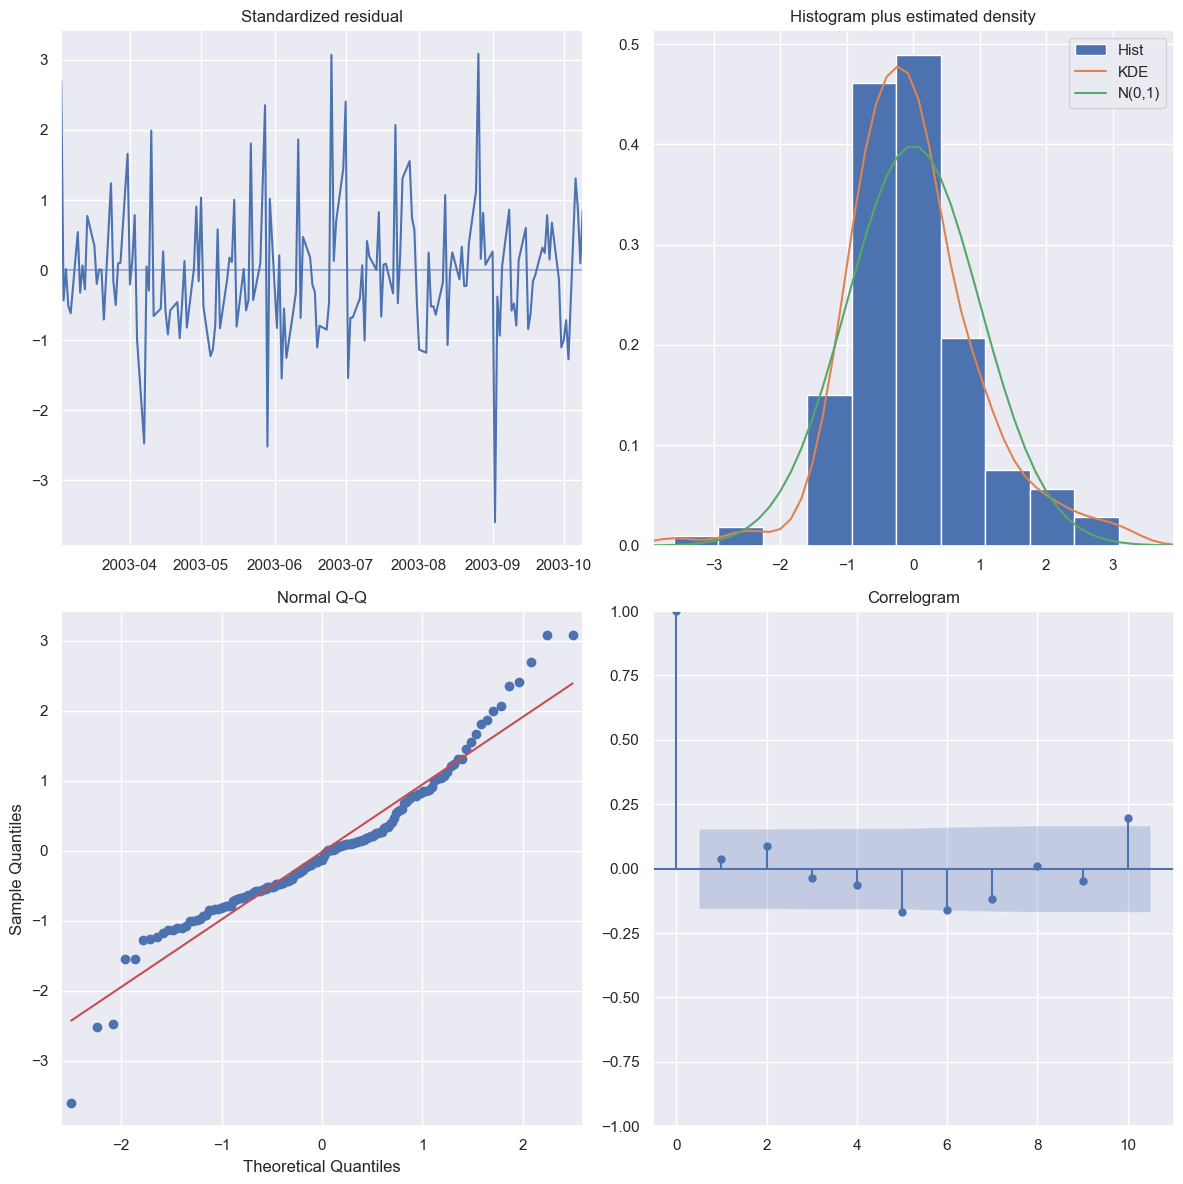

In [27]:
modelX.plot_diagnostics(figsize = (12,12))
plt.tight_layout()
plt.show()

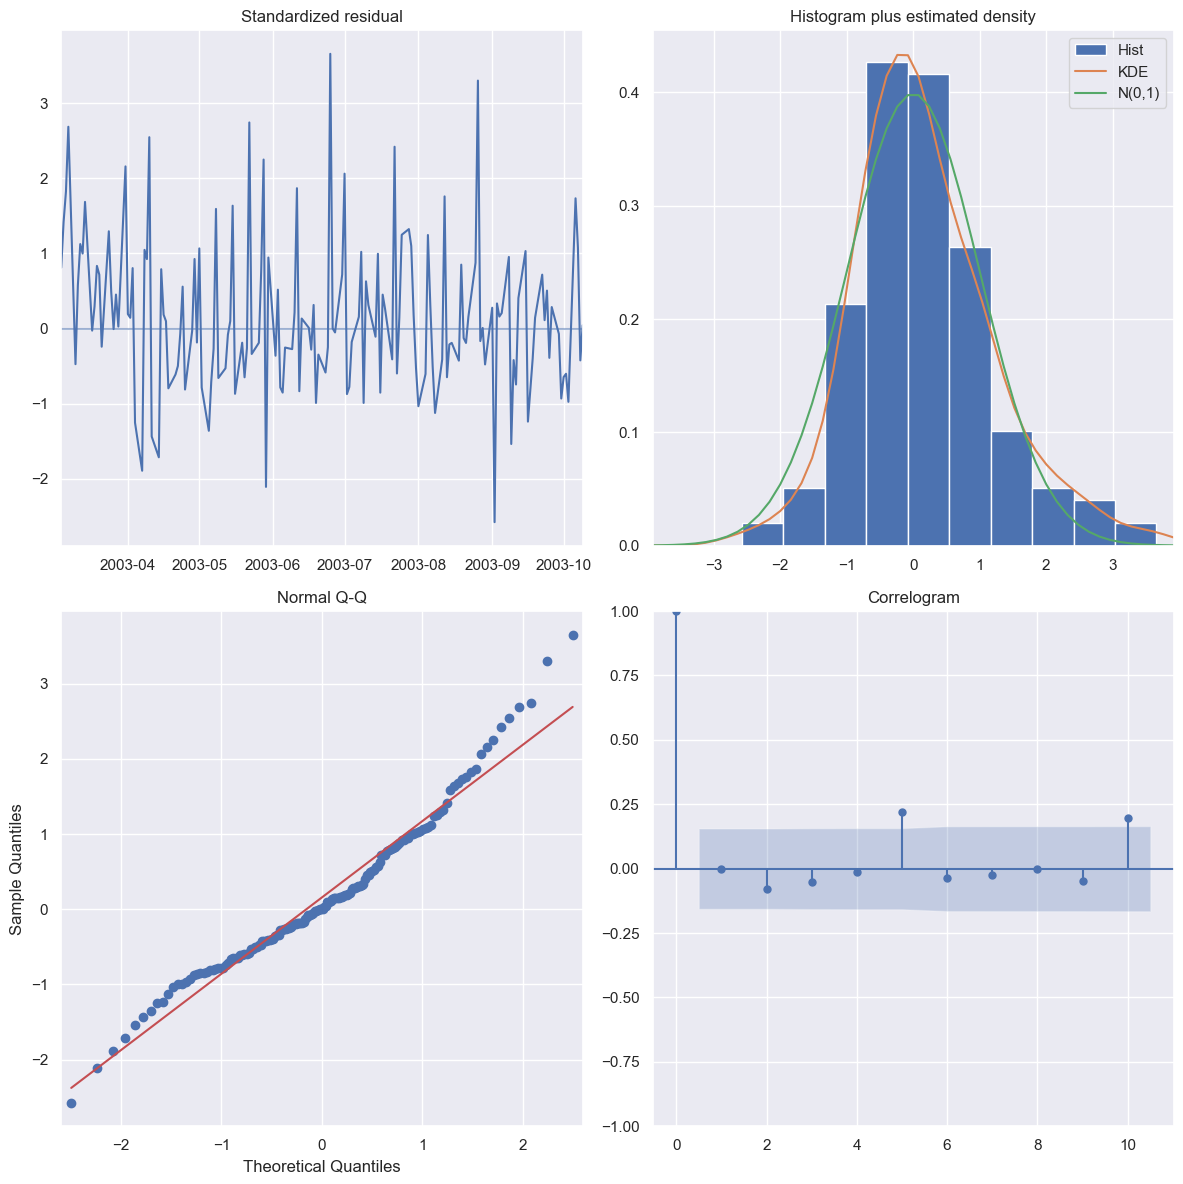

In [28]:
modelY.plot_diagnostics(figsize = (12,12))
plt.tight_layout()
plt.show()

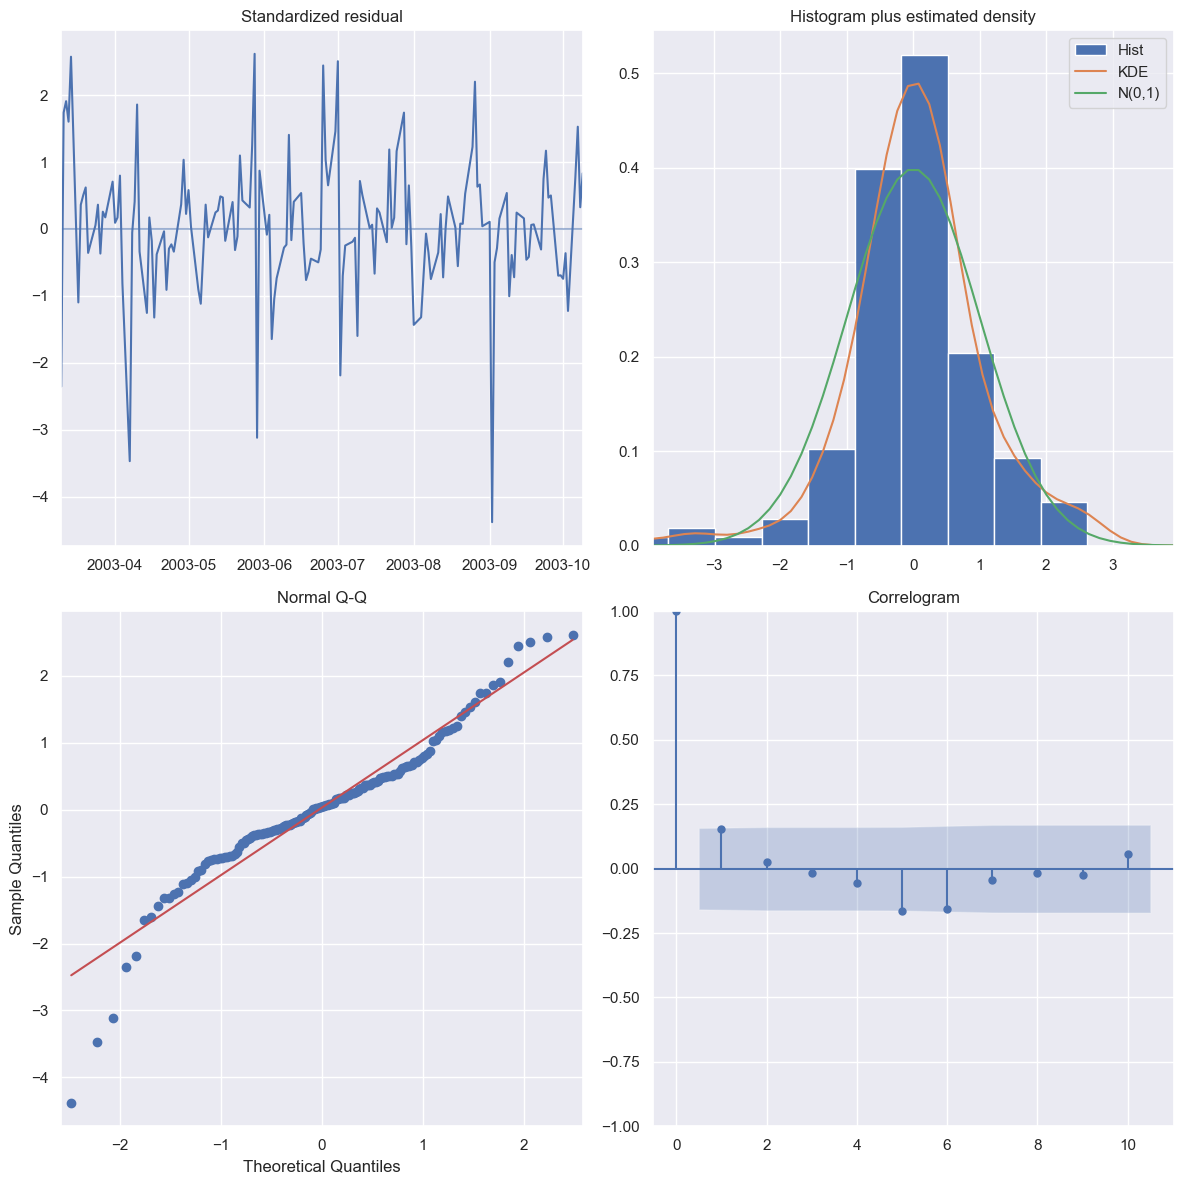

In [29]:
modelZ.plot_diagnostics(figsize = (12,12))
plt.tight_layout()
plt.show()

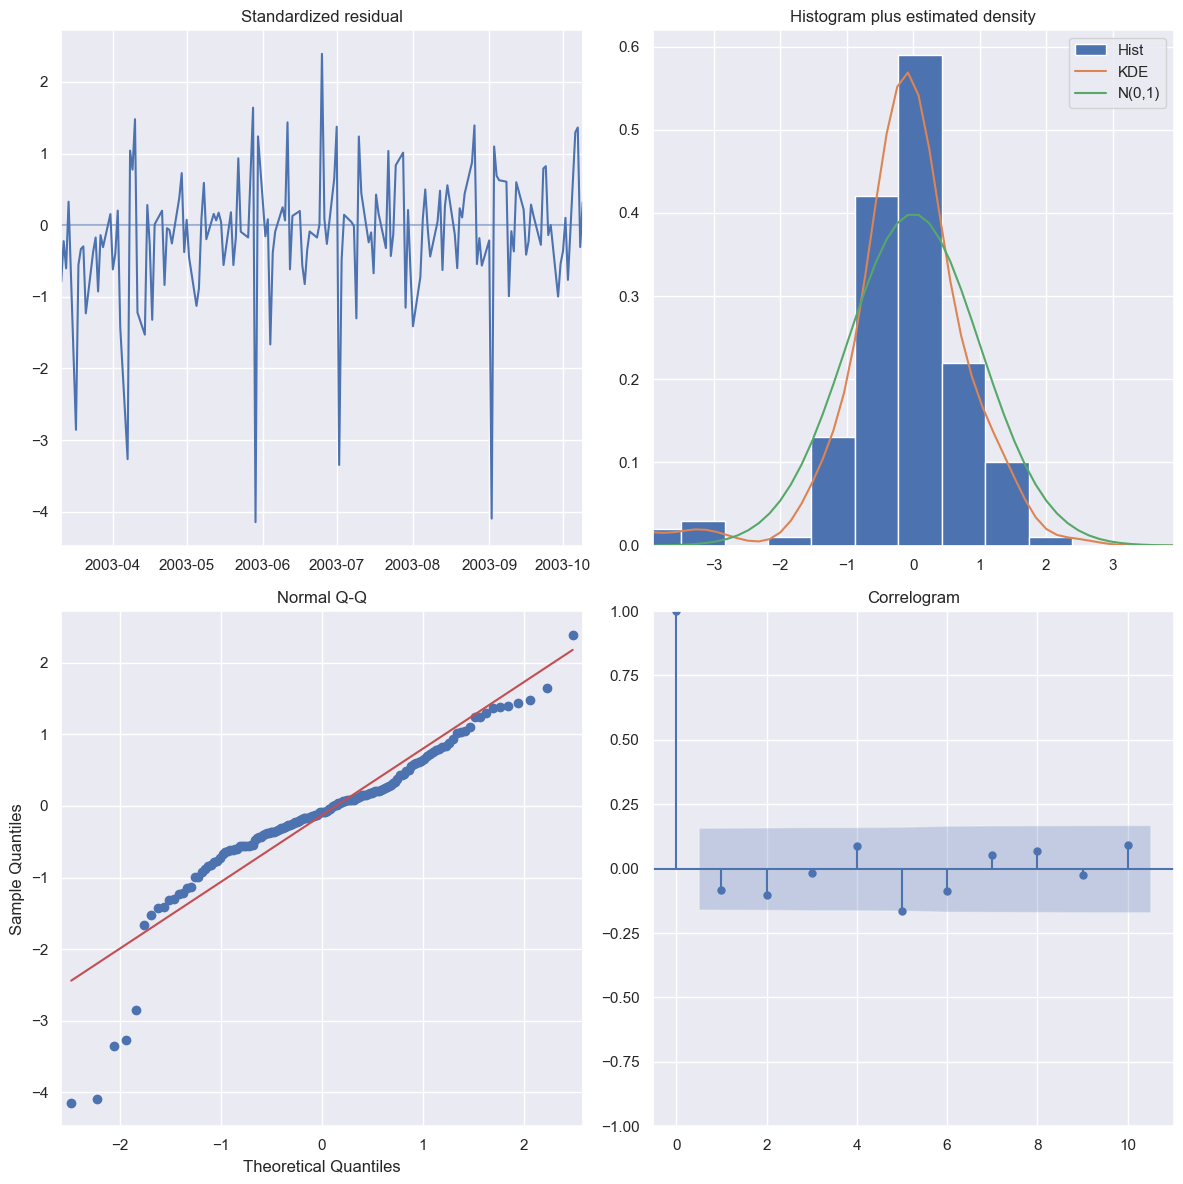

In [30]:
modelK.plot_diagnostics(figsize = (12,12))
plt.tight_layout()
plt.show()

- Do you think you can compare the best fitting models of $X_t$, $Y_t$, $Z_t$, $K_t$ in terms of AIC? Why and why not?

AIC estimates the relative amount of information lost by a given model. The less information a model loses, the better it is at describing the data.

ARIMA(5, 0, 1): 2921.891
ARIMA(5, 1, 5): 2917.653
SARIMA(1, 0, 0)x(0, 1, [1], 5) : 2855.240
SARIMA(1, 1, 2)x(0, 1, [1], 5): 2856.581

Considering the AIC values, best fitting model seems to be Z but there are other evaluationmetrics such as the Bayesian information criterion (BIC), mean squared error (MSE), and root mean squared error (RMSE). It is better to use multiple criteria to evaluate the performance of the models and not rely on a single metric.

- Plot forecasts of the test series for the best models of $X_t$, $Y_t$, $Z_t$, $K_t$

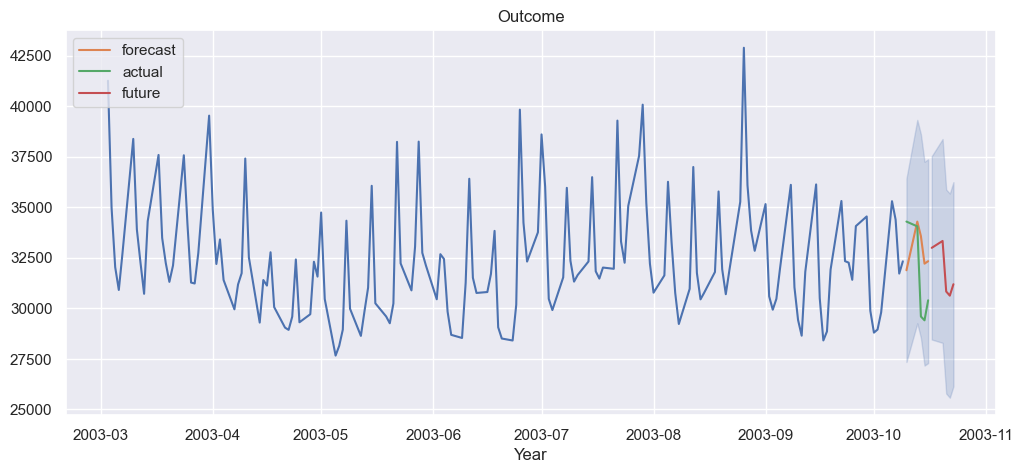

In [31]:
predsX, conf_int = modelX.predict(n_periods = test.shape[0], return_conf_int = True)

x_axis = test.index

plt.figure(figsize = (12,5))
plt.plot(train.x)
plt.plot(predsX, label = "forecast")  
plt.plot(test, label = "actual")  
plt.fill_between(x_axis[-predsX.shape[0]:], conf_int[:, 0], conf_int[:, 1], color='b', alpha = 0.2)

modelX_future = auto_arima(dailySum, seasonal = False)
future_index = pd.date_range('2003-10-17 ', periods=5, freq='b')

predsX_future, conf_int_future = modelX_future.predict(n_periods = 5, return_conf_int = True)
predsX_future.index = future_index
plt.plot(predsX_future, label = "future")  
plt.fill_between(future_index[-predsX_future.shape[0]:], conf_int_future[:, 0], conf_int_future[:, 1], color='b', alpha = 0.2)

plt.legend(loc="upper left")
plt.title("Outcome")
plt.xlabel("Year")
plt.show()

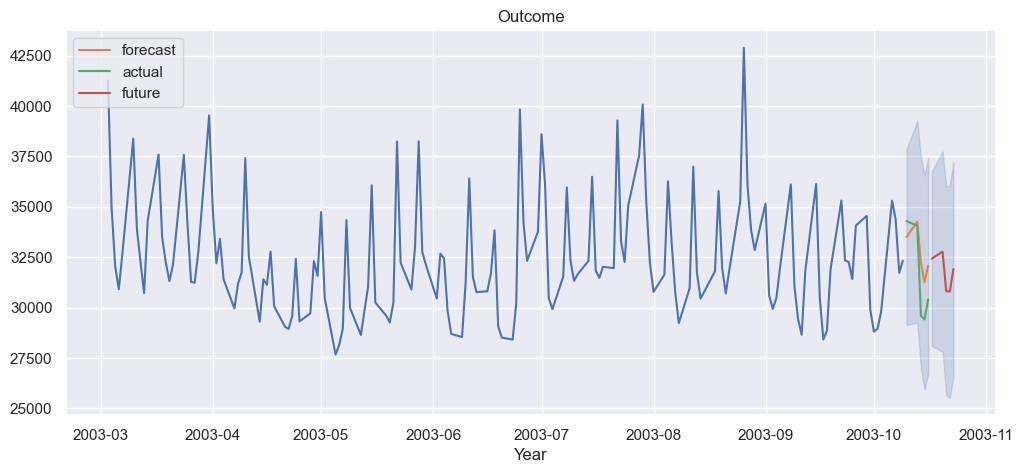

In [32]:
predsY, conf_int = modelY.predict(n_periods = test.shape[0], return_conf_int = True)

x_axis = test.index

plt.figure(figsize = (12,5))
plt.plot(train.x)
plt.plot(predsY, label = "forecast")  
plt.plot(test, label = "actual")  
plt.fill_between(x_axis[-predsY.shape[0]:], conf_int[:, 0], conf_int[:, 1], color='b', alpha = 0.2)

modelY_future = auto_arima(dailySum, seasonal = False, d = 1)
future_index = pd.date_range('2003-10-17 ', periods=5, freq='b')

predsY_future, conf_int_future = modelY_future.predict(n_periods = 5, return_conf_int = True)
predsY_future.index = future_index
plt.plot(predsY_future, label = "future")  
plt.fill_between(future_index[-predsY_future.shape[0]:], conf_int_future[:, 0], conf_int_future[:, 1], color='b', alpha = 0.2)

plt.legend(loc="upper left")
plt.title("Outcome")
plt.xlabel("Year")
plt.show()

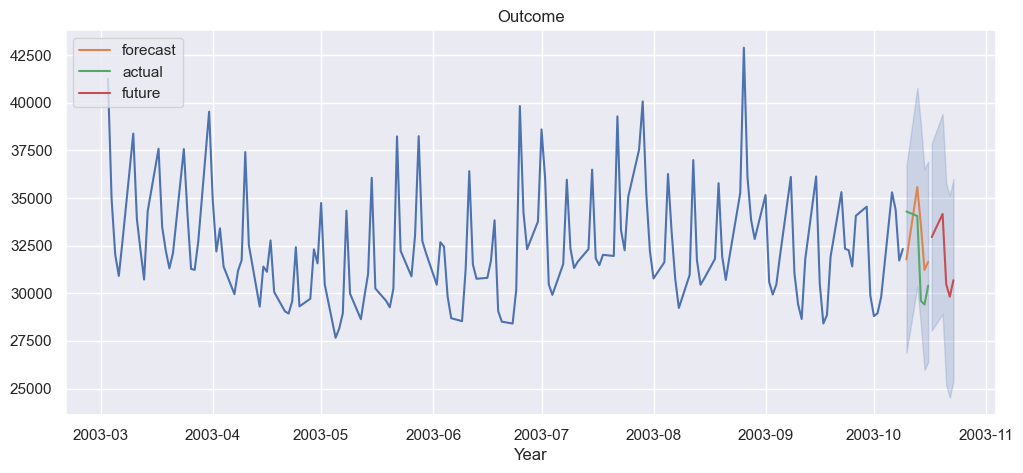

In [33]:
predsZ, conf_int = modelZ.predict(n_periods = test.shape[0], return_conf_int = True)

x_axis = test.index

plt.figure(figsize = (12,5))
plt.plot(train.x)
plt.plot(predsZ, label = "forecast")  
plt.plot(test, label = "actual")  
plt.fill_between(x_axis[-predsZ.shape[0]:], conf_int[:, 0], conf_int[:, 1], color='b', alpha = 0.2)


modelZ_future = auto_arima(dailySum, seasonal = True, m = 5, trace = False,
                   D = 1)
future_index = pd.date_range('2003-10-17 ', periods=5, freq='b')

predsZ_future, conf_int_future = modelZ_future.predict(n_periods = 5, return_conf_int = True)
predsZ_future.index = future_index
plt.plot(predsZ_future, label = "future")  
plt.fill_between(future_index[-predsZ_future.shape[0]:], conf_int_future[:, 0], conf_int_future[:, 1], color='b', alpha = 0.2)

plt.legend(loc="upper left")
plt.title("Outcome")
plt.xlabel("Year")
plt.show()

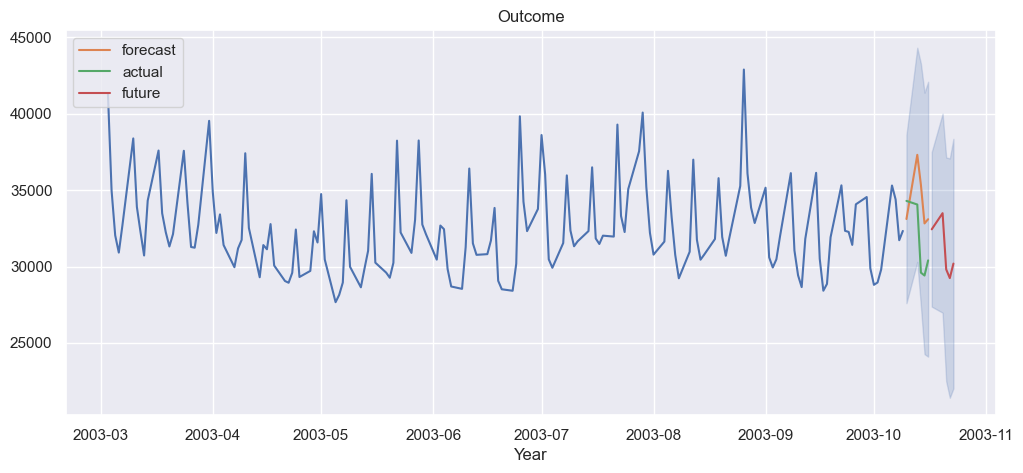

In [34]:
predsK, conf_int = modelK.predict(n_periods = test.shape[0], return_conf_int = True)

x_axis = test.index

plt.figure(figsize = (12,5))
plt.plot(train.x)
plt.plot(predsK, label = "forecast")  
plt.plot(test, label = "actual")  
plt.fill_between(x_axis[-predsK.shape[0]:], conf_int[:, 0], conf_int[:, 1], color='b', alpha = 0.2)

modelK_future = auto_arima(dailySum, seasonal = True, m = 5, trace = False,
                 d=1, D = 1)
future_index = pd.date_range('2003-10-17 ', periods=5, freq='b')
predsK_future, conf_int_future = modelK_future.predict(n_periods = 5, return_conf_int = True)
predsK_future.index = future_index
plt.plot(predsK_future, label = "future")  
plt.fill_between(future_index[-predsK_future.shape[0]:], conf_int_future[:, 0], conf_int_future[:, 1], color='b', alpha = 0.2)

plt.legend(loc="upper left")
plt.title("Outcome")
plt.xlabel("Year")
plt.show()

- Compare the forecasting abilities of the best models of $X_t$, $Y_t$, $Z_t$, $K_t$ interpret. Why do you think the best performing model actually performed the best?

In [35]:
from sklearn.metrics import mean_squared_error

In [36]:
print("Test RMSE for X: %.3f" % np.sqrt(mean_squared_error(test, predsX)))
print("Test RMSE for Y: %.3f" % np.sqrt(mean_squared_error(test, predsY)))
print("Test RMSE for Z: %.3f" % np.sqrt(mean_squared_error(test, predsZ)))
print("Test RMSE for K: %.3f" % np.sqrt(mean_squared_error(test, predsK)))

Test RMSE for X: 2578.734
Test RMSE for Y: 1656.416
Test RMSE for Z: 2423.174
Test RMSE for K: 3574.394


The ARIMA(5, 1, 5) model has the lowest RMSE of 1656.416, followed by the SARIMA(1, 0, 0)x(0, 1, [1], 5) model with a RMSE of 2423.174. A lower RMSE value indicates a better fit of the model to the test data. 

Therefore, based on the test RMSE values, the ARIMA(5, 1, 5) model appears to perform the best among the models you have tested. However, the SARIMA(1, 0, 0)x(0, 1, [1], 5) model also has a relatively low RMSE value, indicating that it may be a good fit for the data as well.

The data obviously have seasonal features and future forecast of the ARIMA(5, 1, 5) model looks very flat and seem to lose its seasonal features. I will go on with tle lowest AIC model SARIMA(1, 0, 0)x(0, 1, [1], 5). This one also is far more simpler.

- Write down the model equation of the best fitting model you found the best forecasting model in the previous step 

$Y_t = 0.3693 Y_{t-1} -0.2381 \epsilon_{t-5}$